In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os 
import requests
import random
import librosa 
import librosa.display
import tensorflow as tf
from sklearn.decomposition import  PCA,TruncatedSVD,FastICA
# from utils import Visualize
from dataloader import DataLoader
import config
from utils import Preprocessing,Animation
from  pathlib  import Path 
print("tensorflow version" ,tf.__version__)
device = tf.config.list_physical_devices()[-1]

tensorflow version 2.6.0


In [3]:
pp =  Preprocessing(config.data['INPUT_PATH'])

df =  pp.get_files()

7501 files read successfully


In [18]:
df.head()

,file,class,label,duration,sr
0,/net/store/cv/users/ybrima/scratch/data/archiv...,0,Jens_Stoltenberg,1.0,16000
1,/net/store/cv/users/ybrima/scratch/data/archiv...,0,Jens_Stoltenberg,1.0,16000
2,/net/store/cv/users/ybrima/scratch/data/archiv...,0,Jens_Stoltenberg,1.0,16000
3,/net/store/cv/users/ybrima/scratch/data/archiv...,0,Jens_Stoltenberg,1.0,16000
4,/net/store/cv/users/ybrima/scratch/data/archiv...,0,Jens_Stoltenberg,1.0,16000


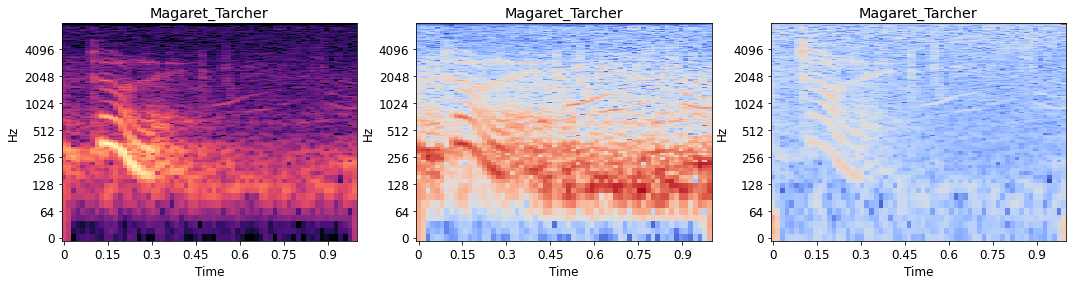

In [76]:
idx =  df.sample(n = 1).index[0]
filename = str(df.iloc[idx,0])

y, sr = librosa.load(filename, sr = None )

S = np.abs(librosa.stft(y, hop_length=512//2, n_fft=1024))
y = librosa.amplitude_to_db(S,ref=np.max)
plt.figure(figsize=(18,4))
plt.subplot(131)
img = librosa.display.specshow(y ,y_axis='log', x_axis='time',sr=sr,hop_length=512//2)
plt.title(str(df.iloc[idx,2]))
plt.subplot(132)
img = librosa.display.specshow(((y  - np.mean(y, axis = 0, keepdims=True))/  np.std(y, axis = 0, keepdims=True) ) ,y_axis='log', x_axis='time', sr=sr,hop_length=512//2)
plt.title(str(df.iloc[idx,2]))
plt.subplot(133)
img = librosa.display.specshow(((y  - np.mean(y, axis = 1, keepdims=True))/  np.std(y, axis = 1, keepdims=True) ) ,y_axis='log', x_axis='time', sr=sr,hop_length=512//2)
plt.title(str(df.iloc[idx,2]))
plt.show()

In [2]:
dl = DataLoader(config.data['file_path2'],keepdims=False, crop_dims= (128,128) )
dl.load()

7501  1 second audio samples created successfully


In [10]:
def resize(y):
    return tf.keras.layers.experimental.preprocessing.Resizing(128,128, name='crop').__call__(y)

In [3]:
def augmentation(input_shape):
    flips =  ["horizontal", "vertical", "horizontal_and_vertical",  "horizontal_and_vertical", "horizontal",  "vertical"]
    inputs =  tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.experimental.preprocessing.RandomCrop(128,128, name='crop').__call__(inputs)
    x = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1).__call__(x)
    x = tf.keras.layers.experimental.preprocessing.RandomFlip(mode = random.choice(flips), seed= tf.random.set_seed(42)).__call__(x)
    x  = tf.keras.layers.experimental.preprocessing.RandomContrast(abs(random.random())).__call__(x)
    model =  tf.keras.Model(inputs,x)
    return model

In [158]:
def generator(dl):
    y =  np.expand_dims(dl.X[np.random.randint(0, dl.X.shape[0])], axis =2)
    input_shape = y.shape 
    model =  augmentation(input_shape=input_shape)

    dx = np.expand_dims(y, axis=0)

    plt.figure(1, figsize=(14,6))
    for i in range(8):
        plt.subplot(2,4, i+1 )
        x =  model(dx)
        # plt.imshow(tf.squeeze(x, 0))
        librosa.display.specshow(tf.squeeze(x, 0).numpy().reshape(128,128))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

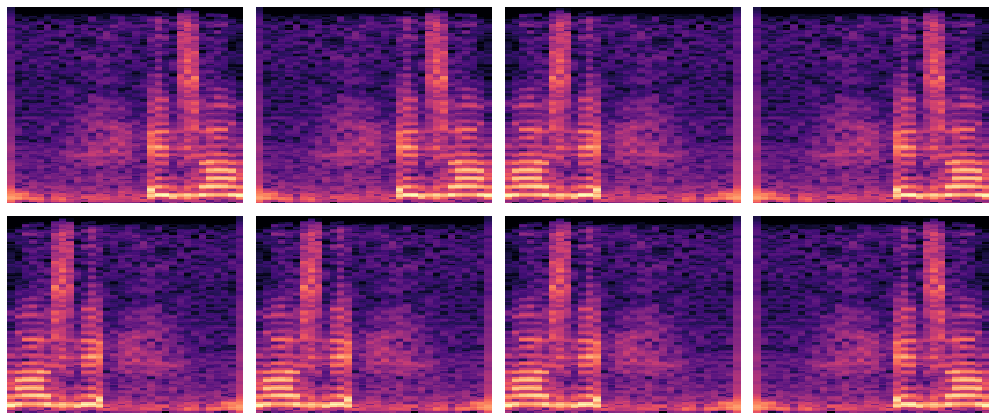

In [164]:
generator(dl)

In [54]:
from tensorflow.keras import layers,Model
from tensorflow import keras
import tensorflow.keras.backend as K

In [49]:
def custom_loss(layer):
    print("This is really working")
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        return K.mean(K.square(y_pred - y_true) + K.square(layer), axis=-1)
   
    # Return a function
    return loss

In [63]:
def nn(input_shape):
    encoder_input = keras.Input(shape=input_shape, name="original_img")
    x = layers.Conv2D(32, 3, activation="relu")(encoder_input)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D(3)(x)
    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu")(x)
    encoder_output = layers.GlobalMaxPooling2D()(x)

    encoder = keras.Model(encoder_input, encoder_output, name="encoder")



    decoder_input = keras.Input(shape=(256,), name="encoded_img")
    x = layers.Reshape((16, 16, 1))(decoder_input)
    x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu")(x)
    x = layers.UpSampling2D(3)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu")(x)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu")(x)
    decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

    decoder = keras.Model(decoder_input, decoder_output, name="decoder")



    autoencoder_input = keras.Input(shape=input_shape, name="img")
    encoded_img = encoder(autoencoder_input)
    decoded_img = decoder(encoded_img)

    autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
    optim_params = dict(learning_rate = 0.003,momentum = 0.9394867962846013,decay = 0.0003)
    
    autoencoder.compile(optimizer=tf.keras.optimizers.SGD(**optim_params), loss=tf.keras.losses.mean_squared_error)
    return encoder, decoder, autoencoder

In [168]:
input_shape = (128, 128,1)

In [ ]:
path =  '/net/store/cv/users/ybrima/scratch/data/archive/16000_pcm_speeches/Benjamin_Netanyau'

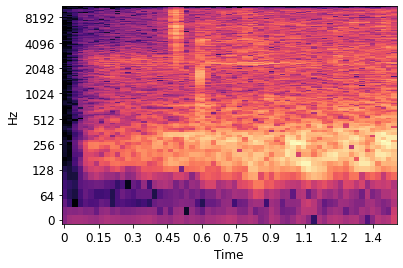

In [172]:
S = np.abs(librosa.stft(dl.Z[0], hop_length=512//2, n_fft=1024))
y = librosa.amplitude_to_db(S,ref=np.max)
img = librosa.display.specshow(y ,y_axis='log', x_axis='time')

In [119]:
encoder, decoder, autoencoder = nn(input_shape)

In [149]:
from sklearn.model_selection import train_test_split

X =  (dl.X - dl.X.mean(axis=0, keepdims=True))/dl.X.std(axis=0,keepdims=True)

# X_train,X_test,y_train,y_test = train_test_split(X,dl.y, test_size=0.1, shuffle=True)
# X_train = np.expand_dims(X_train, -1)
# X_test = np.expand_dims(X_test, -1)

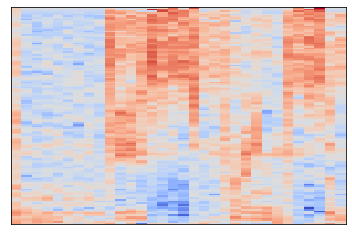

In [157]:
librosa.display.specshow(X[-1])

In [135]:
history = autoencoder.fit(x =  X_train, y = X_train, batch_size=8, epochs=10, verbose=1, validation_data=(X_test,X_test))

Epoch 1/10
844/844 [==============================] - 75s 89ms/step - loss: 0.9967 - val_loss: 1.0294
Epoch 2/10
844/844 [==============================] - 75s 89ms/step - loss: 0.9967 - val_loss: 1.0294
Epoch 3/10
844/844 [==============================] - 75s 89ms/step - loss: 0.9967 - val_loss: 1.0294
Epoch 4/10
844/844 [==============================] - 73s 86ms/step - loss: 0.9967 - val_loss: 1.0294
Epoch 5/10
844/844 [==============================] - 73s 87ms/step - loss: 0.9967 - val_loss: 1.0294
Epoch 6/10
844/844 [==============================] - 74s 87ms/step - loss: 0.9967 - val_loss: 1.0294
Epoch 7/10
844/844 [==============================] - 74s 88ms/step - loss: 0.9967 - val_loss: 1.0294
Epoch 8/10
844/844 [==============================] - 74s 88ms/step - loss: 0.9967 - val_loss: 1.0294
Epoch 9/10
844/844 [==============================] - 78s 92ms/step - loss: 0.9967 - val_loss: 1.0294
Epoch 10/10
844/844 [==============================] - 75s 89ms/step - loss: 0.996

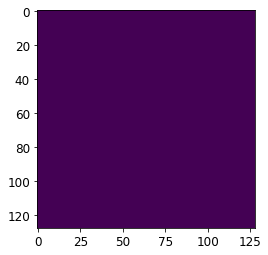

In [148]:
samples = X_train[sample_idx]
latent =  encoder(samples).numpy()
decoded  =  decoder(latent).numpy()
# decoded =  (decoded - decoded.mean(axis=1, keepdims=True))/decoded.std(axis=1,keepdims=True)
plt.imshow(decoded[-1])

In [138]:
np.seterr(divide='ignore', invalid='ignore')
sample_idx = np.random.randint(0,X_train.shape[0], 4)
samples = X_train[sample_idx]
latent =  encoder(samples).numpy()
decoded  =  decoder(latent).numpy()
decoded =  (decoded - decoded.mean(axis=1, keepdims=True))/decoded.std(axis=1,keepdims=True)
fig = plt.figure(1, figsize = (14,8))
locs = [4,5,6,7]
j  = 1
for i, (s, d) in enumerate(zip(samples, decoded)):
  ax = plt.subplot(4,4,i+1)
  pred = d.reshape(128, 128)
  librosa.display.specshow(s.reshape(128, 128), sr=1024,x_axis='time', y_axis='mel', hop_length=512)
  plt.title("Ground Truth")
  ax = plt.subplot(4,4,i+4)
  librosa.display.specshow(pred, sr=1024,x_axis='time', y_axis='mel',hop_length=512//2)
  plt.title("Reconstructed")
  if(i == 3):
    ax = plt.subplot(4,4,i+5)
    librosa.display.specshow(pred, sr=1024, x_axis='time', y_axis='mel',hop_length=512//2)
    plt.title("Reconstructed")
plt.tight_layout()
plt.savefig(f'{config.figures["figpath"]}/Reconstruction_Chart.png', bbox_inches ="tight", dpi=300)
plt.show()

IndexError: cannot do a non-empty take from an empty axes.